# A coupled PO₄–POP model

In this tutorial we will explicitly simulate 2 tracers whose distributions control and feed back on each other.

We consider a simple model for the cycling of phosphorus with 2 state variables consisting of phosphate (PO₄) AKA dissolved inorganic phosphorus (DIP) and particulate organic phosphorus (POP).
The dissolved phases are transported by advection and diffusion whereas the particulate phase sinks rapidly down the water column without any appreciable transport by the circulation.

The governing equations that couple the 3D concentration fields of DIP and POP, denoted $x_\mathsf{DIP}$ and $x_\mathsf{POP}$, respectively, are:

$$\left[\frac{\partial}{\partial t} + \nabla \cdot (\boldsymbol{u} + \mathbf{K}\nabla )\right] x_\mathsf{DIP} = -U(x_\mathsf{DIP}) + R(x_\mathsf{POP}),$$

and

$$\left[\frac{\partial}{\partial t} + \nabla \cdot \boldsymbol{w}\right] x_\mathsf{POP} = U(x_\mathsf{DIP}) - R(x_\mathsf{POP}).$$

The $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \nabla \right]$ and $\nabla \cdot \boldsymbol{w}$ operators represent the ocean circulation and the sinking of particles, respectively.
(Tracer transport operators are described in the documentation.)

The function $U$ represents the biological uptake of DIP by phytoplankton, which we model here as

$$U(x_\mathsf{DIP}) = \frac{x_\mathsf{DIP}}{\tau_\mathsf{DIP}} \, \frac{x_\mathsf{DIP}}{x_\mathsf{DIP} + k} \, (z < z_0),$$

with the timescale, $\tau$, the half-saturation rate $k$, and the depth $z_0$ as parameters.

The function $R$ defines the remineralization rate of POP, which converts POP back into DIP.
For the remineralization, we simply use a linear rate constant, i.e.,

$$R(x_\mathsf{POP}) = \frac{x_\mathsf{POP}}{\tau_\mathsf{POP}}.$$

We start by telling Julia we want to use the AIBECS and the OCIM0.1 circulation for DIP.

In [1]:
using AIBECS
grd, T_OCIM = OCIM0.load()
T_DIP(p) = T_OCIM

┌ Warning: Over-writing registration of the datadep
│   name = AIBECS-OCIM0.1
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/registration.jl:15
┌ Info: You are about to use the OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "Primeau_etal_2013" keys.)
└ @ AIBECS.OCIM0 /Users/runner/work/AIBECS.jl/AIBECS.jl/src/OCIM0.jl:67


T_DIP (generic function with 1 method)

For the sinking of particles, we use the `transportoperator` function

In [2]:
T_POP(p) = transportoperator(grd, z -> w(z,p))

T_POP (generic function with 1 method)

for which we need to define the sinking speed `w(z,p)` as a function of depth `z` and of the parameters `p`.
Following the assumption that $w(z) = w_0 + w' z$ increases linearly with depth, we write it as

In [3]:
function w(z,p)
    @unpack w₀, w′ = p
    return @. w₀ + w′ * z
end

w (generic function with 1 method)

##### Uptake (DIP → POP)

For the uptake, $U$, we write

In [4]:
z = depthvec(grd)
function U(x,p)
    @unpack τ_DIP, k, z₀ = p
    return @. x/τ_DIP * x/(x+k) * (z≤z₀) * (x≥0)
end

U (generic function with 1 method)

where we have "unpacked" the parameters to make the code clearer and as close to the mathematical equation as possible.
(Note we have also added a constraint that `x` must be positive for uptake to happen.)

##### Remineralization (POP → DIP)

For the remineralization, $R$, we write

In [5]:
function R(x,p)
    @unpack τ_POP = p
    return x / τ_POP
end

R (generic function with 1 method)

##### Net sources and sinks

We lump the sources and sinks into `G` functions for DIP and POP.

In [6]:
function G_DIP(DIP, POP, p)
    @unpack DIP_geo, τ_geo = p
    return @. -$U(DIP,p) + $R(POP,p) + (DIP_geo - DIP) / τ_geo
end
function G_POP(DIP, POP, p)
    @unpack τ_geo = p
    return @. $U(DIP,p) - $R(POP,p) - POP / τ_geo
end

G_POP (generic function with 1 method)

where we have imposed a slow restoring of DIP to the global mean `DIP_geo` to prescribe the global mean concentration.
(The `$` signs in front of `U` and `R` protect them from the broadcast macro `@.`)

We now define and build the parameters.

In this tutorial we will specify some initial values for the parameters
and also include units.

In [7]:
import AIBECS: @units, units
import AIBECS: @initial_value, initial_value
using Unitful: m, d, s, yr, Myr, mol, mmol, μmol, μM
@initial_value @units struct PmodelParameters{U} <: AbstractParameters{U}
    w₀::U       |  0.64 | m/d
    w′::U       |  0.13 | m/d/m
    τ_DIP::U    | 230.0 | d
    k::U        |  6.62 | μmol/m^3
    z₀::U       |  80.0 | m
    τ_POP::U    |   5.0 | d
    τ_geo::U    |   1.0 | Myr
    DIP_geo::U  |  2.12 | mmol/m^3
end

initial_value (generic function with 24 methods)

Finally, thanks to the initial values we provided, we can instantiate the parameter vector succintly as

In [8]:
p = PmodelParameters()


│ Row │ Symbol  │ Value   │ Initial value │ Unit     │
│     │ Symbol  │ Float64 │ Float64       │ FreeUni… │
├─────┼─────────┼─────────┼───────────────┼──────────┤
│ 1   │ w₀      │ 0.64    │ 0.64          │ m d⁻¹    │
│ 2   │ w′      │ 0.13    │ 0.13          │ d⁻¹      │
│ 3   │ τ_DIP   │ 230.0   │ 230.0         │ d        │
│ 4   │ k       │ 6.62    │ 6.62          │ μmol m⁻³ │
│ 5   │ z₀      │ 80.0    │ 80.0          │ m        │
│ 6   │ τ_POP   │ 5.0     │ 5.0           │ d        │
│ 7   │ τ_geo   │ 1.0     │ 1.0           │ Myr      │
│ 8   │ DIP_geo │ 2.12    │ 2.12          │ mmol m⁻³ │

We generate the state function `F` and its Jacobian `∇ₓF`,

In [9]:
nb = sum(iswet(grd))
F, ∇ₓF = state_function_and_Jacobian((T_DIP, T_POP), (G_DIP, G_POP), nb)

(AIBECS.var"#F#31"{Tuple{typeof(Main.##296.T_DIP),typeof(Main.##296.T_POP)},AIBECS.var"#tracer#26"{Int64,Int64},AIBECS.var"#G#29"{Tuple{typeof(Main.##296.G_DIP),typeof(Main.##296.G_POP)},AIBECS.var"#tracers#25"{Int64,Int64}}}((Main.##296.T_DIP, Main.##296.T_POP), AIBECS.var"#tracer#26"{Int64,Int64}(191169, 2), AIBECS.var"#G#29"{Tuple{typeof(Main.##296.G_DIP),typeof(Main.##296.G_POP)},AIBECS.var"#tracers#25"{Int64,Int64}}((Main.##296.G_DIP, Main.##296.G_POP), AIBECS.var"#tracers#25"{Int64,Int64}(191169, 2))), AIBECS.var"#∇ₓF#34"{AIBECS.var"#T#27"{Tuple{typeof(Main.##296.T_DIP),typeof(Main.##296.T_POP)}},AIBECS.var"#∇ₓG#33"{Tuple{typeof(Main.##296.G_DIP),typeof(Main.##296.G_POP)},Int64,Int64}}(AIBECS.var"#T#27"{Tuple{typeof(Main.##296.T_DIP),typeof(Main.##296.T_POP)}}((Main.##296.T_DIP, Main.##296.T_POP)), AIBECS.var"#∇ₓG#33"{Tuple{typeof(Main.##296.G_DIP),typeof(Main.##296.G_POP)},Int64,Int64}((Main.##296.G_DIP, Main.##296.G_POP), 191169, 2)))

generate the steady-state problem,

In [10]:
@unpack DIP_geo = p
x = DIP_geo * ones(2nb) # initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004  …  0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004]

and solve it

In [11]:
sol = solve(prob, CTKAlg()).u

382338-element Array{Float64,1}:
 0.0020967060231695794
 0.0021333454639564067
 0.0018399997020588973
 0.0017256341824095432
 0.0016123285857802608
 0.0015535540266708382
 0.0014585415653198225
 0.0015700081072968063
 0.001457342544840602
 0.0013585026849788466
 ⋮
 2.788346861680536e-9
 1.6701226349912944e-9
 1.829371012908755e-9
 2.873136469226821e-9
 2.993647120880922e-9
 2.8588624377828684e-9
 3.2379918118331016e-9
 3.090096766550593e-9
 3.1845337501750665e-9

We can look at different the DIP and POP fields using the Plots.jl recipes.

In [12]:
DIP, POP = state_to_tracers(sol, grd) # unpack tracers

([0.0020967060231695794, 0.0021333454639564067, 0.0018399997020588973, 0.0017256341824095432, 0.0016123285857802608, 0.0015535540266708382, 0.0014585415653198225, 0.0015700081072968063, 0.001457342544840602, 0.0013585026849788466  …  0.0014112751669096634, 0.0014122643065740373, 0.0013911523315448021, 0.0013911433495680053, 0.0021377405632157323, 0.002139399333554897, 0.002135737129872544, 0.002124992953431945, 0.002134475636273301, 0.0021379362067726316], [2.6134960067747894e-5, 2.6593099800842613e-5, 2.2925108033787846e-5, 2.1495086727776714e-5, 2.007832138111051e-5, 1.9343409624185406e-5, 1.81553845875989e-5, 1.9549149860315477e-5, 1.8140392190458104e-5, 1.6904513204809395e-5  …  3.040829677838551e-9, 2.788346861680536e-9, 1.6701226349912944e-9, 1.829371012908755e-9, 2.873136469226821e-9, 2.993647120880922e-9, 2.8588624377828684e-9, 3.2379918118331016e-9, 3.090096766550593e-9, 3.1845337501750665e-9])

First, let's look at the mean profile

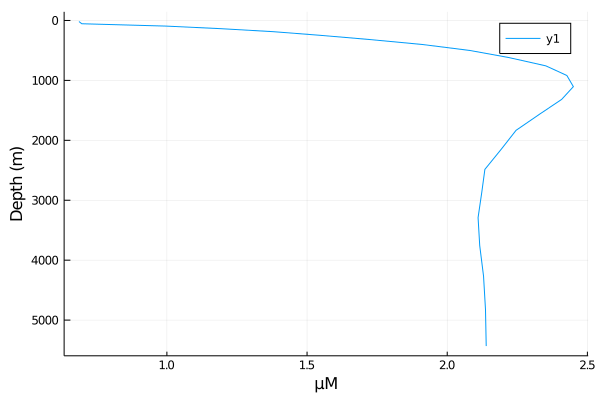

In [13]:
using Plots
plothorizontalmean(DIP * (mol/m^3) .|> μM, grd)

We can plot the concentration of DIP at a given depth via, e.g.,

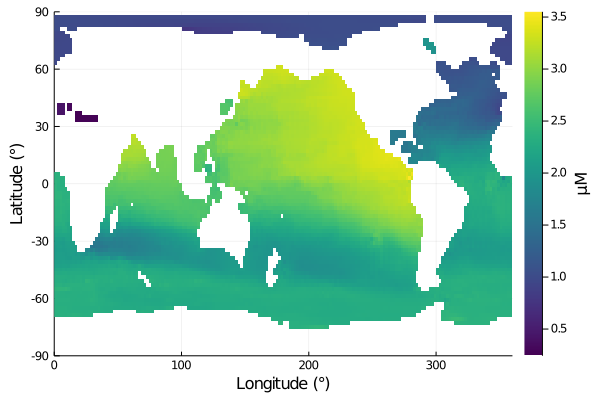

In [14]:
plothorizontalslice(DIP * (mol/m^3) .|> μM, grd, depth=1000m, color=:viridis)

Or have a look at a map of the uptake at the surface

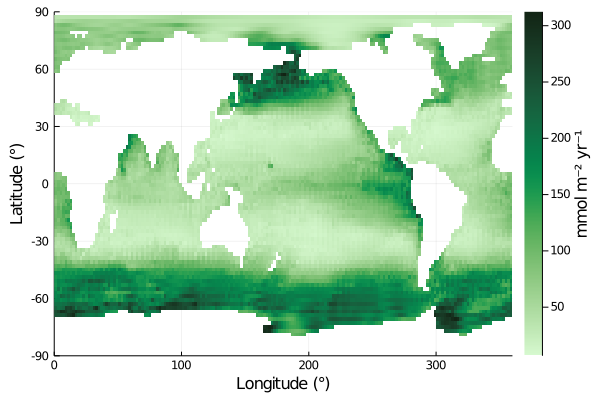

In [15]:
plotverticalintegral(U(DIP,p) * (mol/m^3/s) .|> mmol/yr/m^3, grd, color=:algae)

Or look at what is exported below 500 m

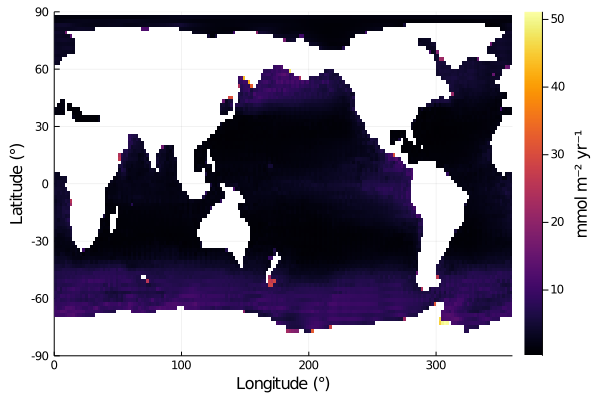

In [16]:
plothorizontalslice(POP .* w(z,p) * (mol/m^3*m/s) .|> mmol/yr/m^2, grd, depth=500m, color=:inferno, rev=true)

Now let's make our model a little fancier and use a fine topographic map to refine the remineralization profile.
For this, we will use the ETOPO dataset, which can be downloaded by AIBECS via

In [17]:
iwet = findall(vec(iswet(grd))) # the wet-box indices
f_topo = ETOPO.fractiontopo(grd)[iwet]

┌ Warning: Binning ETOPO to grd. This may take a few seconds
└ @ AIBECS.ETOPO /Users/runner/work/AIBECS.jl/AIBECS.jl/src/ETOPO.jl:104
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 55ebef118c1bd4d8682464d4d24f0d0850d24160c996d1ff62ca496010ffdf61
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/verification.jl:44
┌ Info: You are about to use the ETOPO data set.
│ If you use it for research, please cite:
│ 
│ - Amante, C. and B.W. Eakins, 2009. ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. NOAA Technical Memorandum NESDIS NGDC-24. National Geophysical Data Center, NOAA. doi:10.7289/V5C8276M [access date].
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "Amante_Eakins_2009" key.)
└ @ AIBECS.ETOPO /Users/runner/work/AIBECS.jl/AIBECS.jl/src/ETOPO.jl:50


191169-element Array{Float64,1}:
 0.0006887052341597796
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

We then must redefine the transport operator for sinking particles to take into consideration the subgrod topography.

In [18]:
T_POP2(p) = transportoperator(grd, z -> w(z,p); is_seafloor=f_topo)

T_POP2 (generic function with 1 method)

With this new vertical transport for POP, we can recreate our problem and solve it again

In [19]:
F2, ∇ₓF2 = state_function_and_Jacobian((T_DIP, T_POP2), (G_DIP, G_POP), nb)
prob2 = SteadyStateProblem(F2, ∇ₓF2, x, p)
sol2 = solve(prob2, CTKAlg()).u
DIP2, POP2 = state_to_tracers(sol2, grd) # unpack tracers

([0.002098085071985419, 0.002134322122258573, 0.0018409833130442763, 0.0017266705901693824, 0.0016137061456329537, 0.0015554917832498708, 0.001460712294657363, 0.0015728691982201247, 0.0014603298577994658, 0.0013625583518125377  …  0.001421355490676489, 0.001422355334171355, 0.00140136514200497, 0.0014013599107095258, 0.002140746929381227, 0.00214240310824099, 0.002138758544910777, 0.002128077189725212, 0.0021375005840975183, 0.0021409435430918148], [2.6159857260764577e-5, 2.660531194275349e-5, 2.2937407071761337e-5, 2.1508045912111316e-5, 2.0095546275674554e-5, 1.936763914142123e-5, 1.8182527108018393e-5, 1.9584924672885265e-5, 1.81777451666206e-5, 1.6955224585930124e-5  …  3.1092058441248986e-9, 2.87165505265986e-9, 1.8040447193455178e-9, 1.977252650928084e-9, 2.9378792363935514e-9, 3.0701301969669153e-9, 2.9462721482356186e-9, 3.2997240879138307e-9, 3.1590417354099493e-9, 3.266028827606929e-9])

Let's check the difference between the modelled DIP with and without the subgrid topography

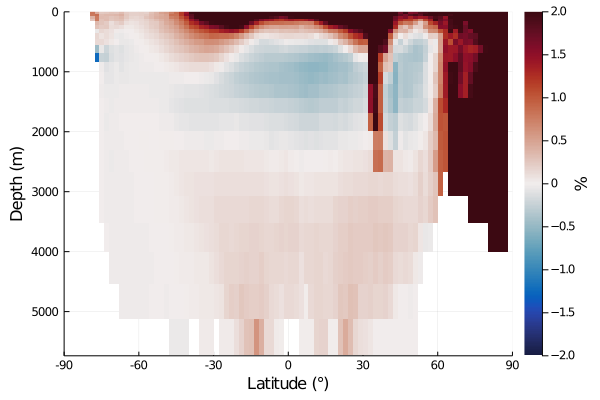

In [20]:
plotzonalaverage((DIP2 - DIP) ./ DIP .|> u"percent", grd, color=:balance, clim=(-2, 2))

This zonal average shows how much DIP is prevented from sinking out of the surface layers with the new subgrid parameterization.
Interestingly, there is a also an increase of DIP in the deep waters, too!

Let's look at the vertical average.

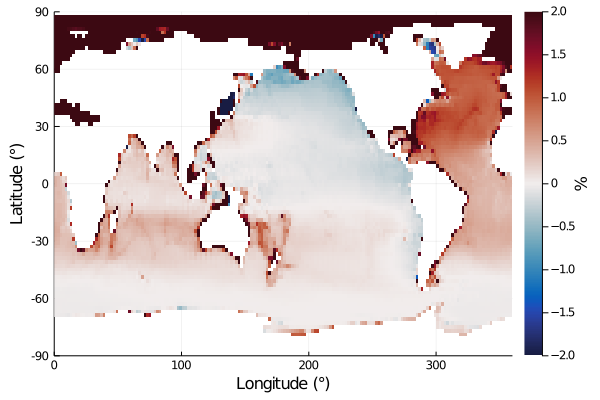

In [21]:
plotverticalaverage((DIP2 - DIP) ./ DIP .|> u"percent", grd, color=:balance, clim=(-2, 2))

It's interesting to see that this change for the sinking particles, which mostly increases the remineralization rate on the continental shelf, also has basin-wide impacts.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*